# Week 6 Lab code: test error (out-of-sample error) versus model complexity
 - review of training error and test error
 - from linear regression to ploynomial regression
 - sampling data from data set
 - bias versus variance

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
%matplotlib inline

In [3]:
plt.style.use('seaborn-white')

## We shall focus on Auto data set, and we are interested in MPG versus horsepower
You should download auto.csv from Course content

In [4]:
df1 = pd.read_csv('Auto.csv', na_values='?').dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## Let's look at the columns of interest: horsepower as x and mpg as y

In [110]:
x = df1.horsepower.values.reshape(-1,1)

In [111]:
y = df1.mpg.values

### The following set up is to make the figure more readable.  

In [131]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

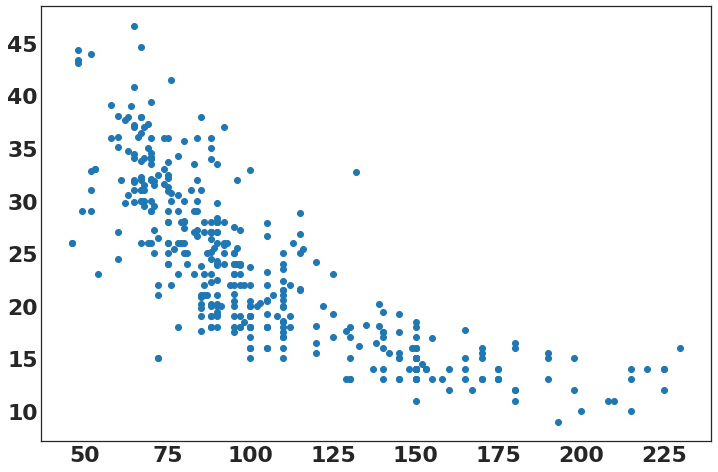

In [135]:
plt.figure(figsize=(12,8))
plt.scatter(x,y)

# Let's review and warmup by using linear regression to do the followings
 - split the data into training and test subsets
 - train the model with training subset
 - make prediction for training subset and calculate the training error
 - likewise for test subset, and get our important result, the "test error"
 - plot our model prediction with training data in background

In [136]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=1)

model = skl_lm.LinearRegression()

model.fit(X_train,y_train)

LinearRegression()

In [137]:
pred_train = model.predict(X_train)

train_error = mean_squared_error(y_train, pred_train)

print('Training error for linear model: %.3f' % train_error)

Training error for linear model: 23.172


In [138]:
pred = model.predict(X_test)

test_error = mean_squared_error(y_test, pred)

print('Test error for linear model: %.3f' % test_error)

Test error for linear model: 24.802


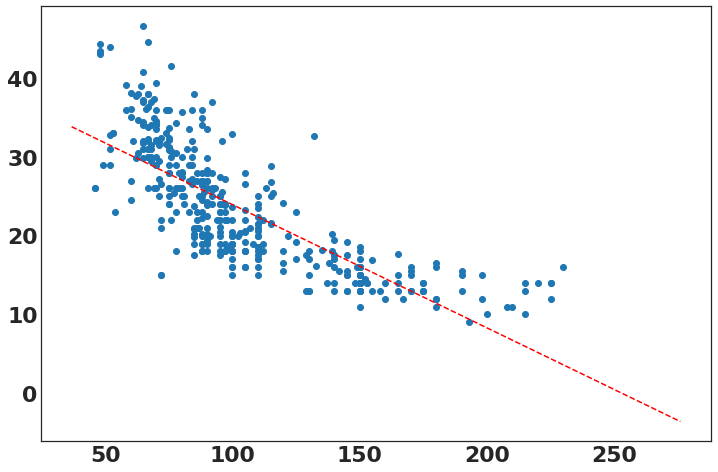

In [141]:
X_plot=np.linspace(min(x)*0.8,max(x)*1.2,100)

plt.figure(figsize=(12,8))
plt.plot(X_plot,model.predict(X_plot),'r--')
plt.scatter(x,y)

## Now we see the above model does not fit the data too well. We are going to learn how to use quadratic regression to fit the data. The quadratic model means $f(x)=ax^2+bx+c$

## We can still use "linear" regression to solve the quadratic model as long as we have extra feature in $x^2$ 

In [142]:
degree = 2

poly = PolynomialFeatures(degree)

x_poly = poly.fit_transform(x)

### The above cell is very important!!!. But what it does is very simple. 

In [147]:
x.shape

(392, 1)

In [143]:
x_poly.shape

(392, 3)

### The new matrix x_poly is made out of x. The zero power of x is placed in the first column, first power in second column, and the second power in the third column. We can confirm by reading the matrix elements.

In [148]:
x_poly[0,:]

array([1.00e+00, 1.30e+02, 1.69e+04])

In [149]:
x_poly[1,:]

array([1.0000e+00, 1.6500e+02, 2.7225e+04])

## We can plot the second column and third column to show the points $(x,x^2)$ form a quadratic curve. 

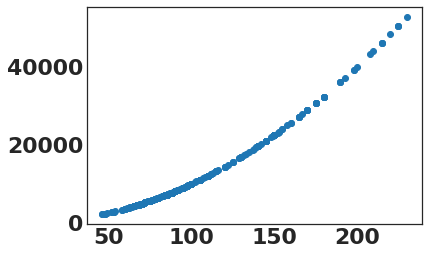

In [146]:
plt.scatter(x_poly[:,1],x_poly[:,2])

## Now we can continue using the linear regression to do quadratic regression. The only difference is to use x_poly instead of x. 

In [150]:
X_train, X_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.5, random_state=1)

model = skl_lm.LinearRegression()

model.fit(X_train,y_train)

LinearRegression()

In [151]:
pred_train = model.predict(X_train)

train_error = mean_squared_error(y_train, pred_train)

print('Training error for quadratic model: %.3f' % train_error)

Training error for quadratic model: 19.450


In [152]:
pred = model.predict(X_test)

test_error = mean_squared_error(y_test, pred)

print('Test error for quadratic model: %.3f' % test_error)

Test error for quadratic model: 18.848


In [153]:
X_plot = poly.fit_transform(X_plot)

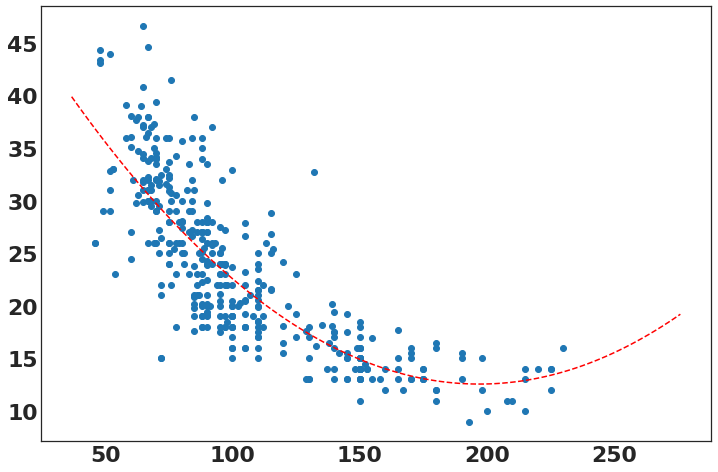

In [154]:
plt.figure(figsize=(12,8))
plt.plot(X_plot[:,1],model.predict(X_plot),'r--')
plt.scatter(x,y)

## We give a brief summary on comparing the linear model against quadratic model
 - Training error: 23.17 (linear) vs 19.45 (quadratic)
 - Test error: 24.8 (linear) vs 18.85 (quadratic)
 - The plot of quadratic model looks better

# -------------------------------------------------------------------------------

## Now we see quadratic model does better than linear model. Bias-variance tradeoff tells  us no model is perfect. A simple concept here is: the more sensitive the model is, the bigger variance in prediction. Quadratic model is more sensitive than linear model.  

### Next, we shall see how to extract the infomration of "bias" and "variance" from the following simulations. In details, we shall do
 - Do linear regression 50 times, each time the split of training and test subsets are random
 - Record the test error from each run (so we have 50 test errors from linear model)
 - Do quadratci regression 50 times, each time split is random. We record the test error.
 - Repeat the same procedure on running cubic regression, quartic, ..., to power of ten.

In [155]:
t_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,50)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df1.mpg.ravel(),
                                                        test_size=t_prop, random_state=Y[i,j])
                                                                        
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

## Hence, we record all sequeces of test errors in the matrix Z

In [156]:
Z.shape

(10, 50)

### Do the average of test error along each row.

In [157]:
bias = Z.mean(1)

### Calculate the variance for each row of data

In [158]:
var = np.sqrt(Z.var(1))

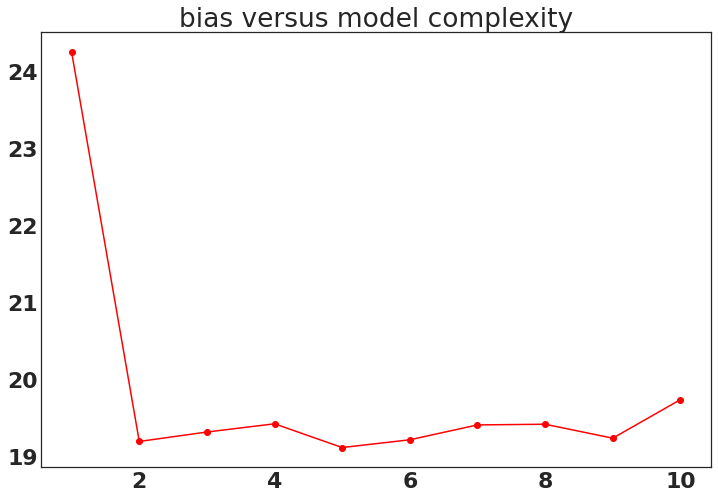

In [164]:
plt.figure(figsize=(12,8))
plt.title('bias versus model complexity')
plt.plot(p_order,bias,'r-o')

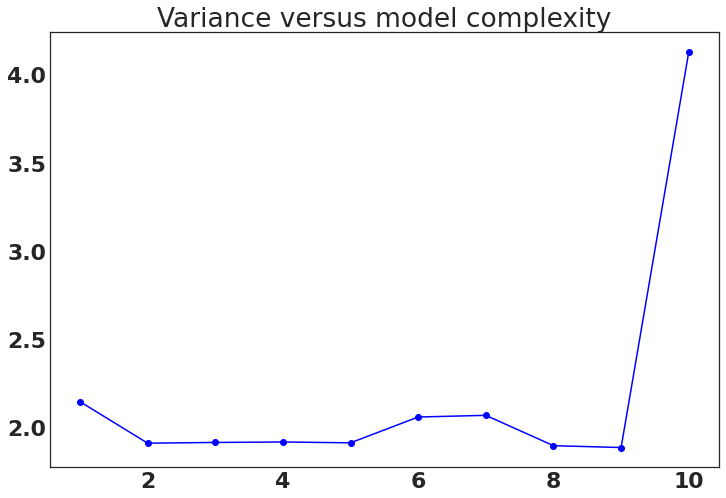

In [165]:
plt.figure(figsize=(12,8))
plt.title('Variance versus model complexity')
plt.plot(p_order,var,'b-o')

## Brief summary of above two plots concerning bias and variance.
 - They are quantities related to the test error, which is used to estimate how model performs on unseen data
 - Bias is the average of the test errors we get from using different training subsets
 - Variance is the variance of sequence of test errors we get from using different training subsets
 - Complex model (high polynomial order) tend to have lower bias (mean test error) but higher variance
 - Simple model (such as linear) tend to have higher bias but lower variance

# -----------------------

### In the last demo, we use package "mlxtend" to evaluate the bias and variance. The following results are qualitatively the same, but detail numeric values are a bit different. 

In [167]:
from mlxtend.evaluate import bias_variance_decomp


mseV = np.zeros(len(p_order))
biasV = np.zeros(len(p_order))
varV = np.zeros(len(p_order))


for i in p_order:
    
    degree = i
    
    poly = PolynomialFeatures(degree)
    x_poly = poly.fit_transform(x)
    
    X_train, X_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.5, random_state=1)
    model = skl_lm.LinearRegression()
    
    mseV[i-1], biasV[i-1], varV[i-1] = bias_variance_decomp(model, X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=1)


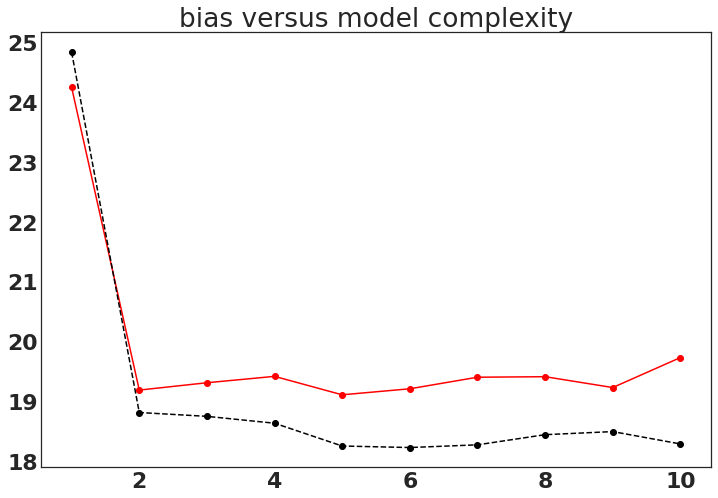

In [169]:
plt.figure(figsize=(12,8))
plt.title('bias versus model complexity')
plt.plot(p_order,bias,'r-o')
plt.plot(p_order,biasV,'k--o')

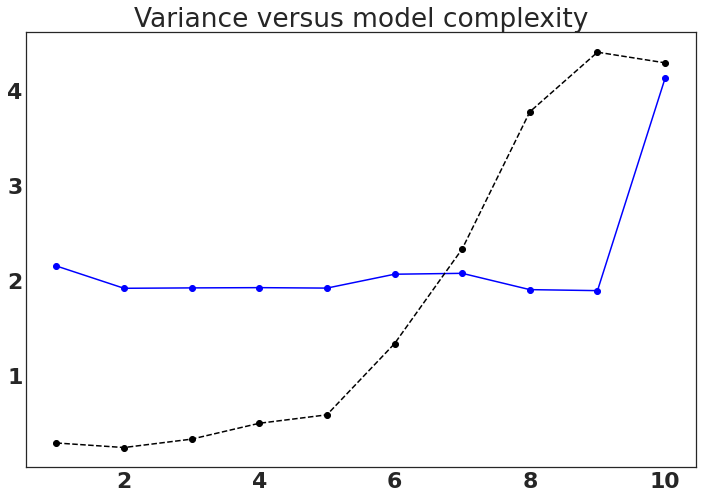

In [170]:
plt.figure(figsize=(12,8))
plt.title('Variance versus model complexity')
plt.plot(p_order,var,'b-o')
plt.plot(p_order,varV,'k--o')